# Gaussian Process Regression on a Mesh with **GPyTorch**

This notebooks shows how to fit a [GPyTorch](https://gpytorch.ai/) Gaussian process (GP) on a mesh.

In [1]:
# Import a backend, we use torch in this example.
import gpytorch
import torch

# Import the geometric_kernels backend.
import geometric_kernels
import geometric_kernels.torch

# Import the Mesh space and the general-purpose MaternGeometricKernel
from geometric_kernels.spaces.mesh import Mesh
from geometric_kernels.kernels import MaternGeometricKernel

# The GPyTorch frontend of GeometricKernels
from geometric_kernels.frontends.gpytorch import GPyTorchGeometricKernel

# Sampling routines we will use to create a dummy dataset
from geometric_kernels.kernels import default_feature_map
from geometric_kernels.sampling import sampler
from geometric_kernels.utils.utils import make_deterministic

# Stuff
import numpy as np
import optax
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path

INFO: Using numpy backend


## Mesh Plotting Utils for `plotly`

In [2]:
def update_figure(fig):
    """Utility to clean up figure"""
    fig.update_layout(scene_aspectmode="cube")
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
    # fig.update_traces(showscale=False, hoverinfo="none")
    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

    fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", paper_bgcolor="rgba(0,0,0,0)")
    fig.update_layout(
        scene=dict(
            xaxis=dict(showbackground=False, showticklabels=False, visible=False),
            yaxis=dict(showbackground=False, showticklabels=False, visible=False),
            zaxis=dict(showbackground=False, showticklabels=False, visible=False),
        )
    )
    return fig

def plot_mesh(mesh: Mesh, vertices_colors = None, **kwargs):
    plot = go.Mesh3d(
        x=mesh.vertices[:, 0],
        y=mesh.vertices[:, 1],
        z=mesh.vertices[:, 2],
        i=mesh.faces[:, 0],
        j=mesh.faces[:, 1],
        k=mesh.faces[:, 2],
        intensity=vertices_colors,
        **kwargs
    )
    return plot

## Defining a Space

First, we create a GeometricKernels space that corresponds to a teddy bear mesh loaded from "../data/teddy.obj"

In [3]:
mesh = Mesh.load_mesh(str(Path.cwd().parent / "data" / "teddy.obj"))
print("Number of vertices in the mesh:", mesh.num_vertices)

Number of vertices in the mesh: 1598


Now we actually visualize the mesh.

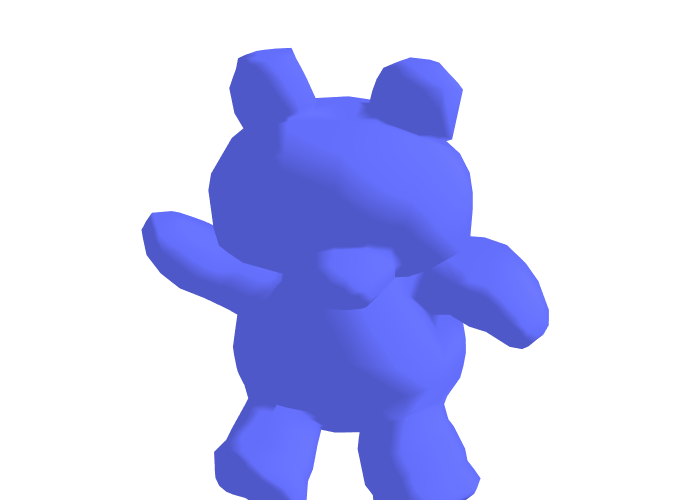

In [4]:
# Define the camera
camera = dict(
    up=dict(x=0, y=1, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=0.7, z=1.25)
)

plot = plot_mesh(mesh)
fig = go.Figure(plot)
update_figure(fig)
fig.update_layout(
    scene_camera=camera
)
fig.show("png")

## Create a Dummy Dataset on the Mesh

We sample from the prior of a GP to create a simple dataset we can afterwards fit using an exact Gaussian process regression (GPR) model.

The input set $X \in \mathbb{N}^{n \times 1}$ consists of **indices** enumerating vertices of the mesh. Consequently, the elements of $X$ are in $[0, N_v-1]$, where $N_v$ are the number of vertices in the mesh.
We sample `num_data` of them into the tensor called `xs_train`. For test inputs `xs_test`, we use the whole $X$.

In [5]:
num_data = 50
key = torch.Generator()
key.manual_seed(1234)

xs_train = torch.randint(low=0, high=mesh.num_vertices, size=(num_data, 1), generator=key, dtype=torch.int64)
xs_test = torch.arange(mesh.num_vertices, dtype=torch.int64)[:, None]
# print("xs_train:", xs_train)
# print("xs_test:", xs_test)

To generate the corresponding outputs `ys_train` and `ys_test`, we sample from the prior. To do this, we create a `MaternGeometricKernel` object and use the efficent sampling functionality of GeometricKernels.

In [6]:
base_kernel = MaternGeometricKernel(mesh)

params = base_kernel.init_params()
params["lengthscale"] = torch.tensor([5.0], dtype=torch.float64)
params["nu"]  = torch.tensor([2.5], dtype=torch.float64)

feature_map = default_feature_map(kernel=base_kernel)
sample_paths = make_deterministic(sampler(feature_map), key)

_, ys_train  = sample_paths(xs_train, params)
key, ys_test = sample_paths(xs_test,  params)
ys_train = ys_train[:, 0]
ys_test = ys_test[:, 0]

assert(torch.allclose((ys_test[xs_train[:, 0]]), ys_train))

## Build a GPyTorch Model

Now we wrap the `base_kernel` created above into the `GPyTorchGeometricKernel` to make an actual GPyTorch kernel.

**Note:** `params` are external to the `base_kernel` object, thus we need to pass them to the `GPyTorchGeometricKernel` explicitly.
Otherwise it will use `params = base_kernel.init_params()`.
The `trainable_nu` parameter changes whether to treat the smoothness parameter `"nu"` as trainable or fixed. `trainable_nu = True` only works for finite values of `"nu"`, it is incompatible with `nu = inf`.

**Note:** aligning with the standard GPyTorch conventions, `GPyTorchGeometricKernel` does not maintain a variance (outputscale) parameter.
To add it, we wrap it into the `gpytorch.kernels.ScaleKernel`.

In [7]:
kernel = gpytorch.kernels.ScaleKernel(
            GPyTorchGeometricKernel(
                base_kernel,
                nu = params["nu"],
                lengthscale=params["lengthscale"],
                trainable_nu=False
            )
         )
kernel.outputscale = 1.0

We use the data `xs_train`, `ys_train` and the GPyTorch kernel `kernel` to construct a GPyTorch model.

In [8]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel

    def forward(self, x):  # pylint: disable=arguments-differ
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-6)
)
likelihood.noise = torch.tensor(1e-4)

model = ExactGPModel(xs_train, ys_train, likelihood, kernel)

# use float64:
model.double()
likelihood.double()

print("Initial model:")
print("kernel.base_kernel.nu =", model.covar_module.base_kernel.nu)
print("kernel.base_kernel.lengthscale =", model.covar_module.base_kernel.lengthscale)
print("kernel.outputscale =", model.covar_module.outputscale)
print("likelihood.obs_noise =", model.likelihood.noise)
print("")

# Note: this is divided by the number of data points, hence may appear
# quite different from the marginal log likelihoods of other frontends.
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

print("Initial negative log marginal likelihood:", -mll(model(xs_train), ys_train).detach().numpy())

Initial model:
kernel.base_kernel.nu = tensor([2.5000], dtype=torch.float64)
kernel.base_kernel.lengthscale = tensor([[5.0000]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
kernel.outputscale = tensor(1.0000, dtype=torch.float64, grad_fn=<SoftplusBackward0>)
likelihood.obs_noise = tensor([0.0001], dtype=torch.float64, grad_fn=<AddBackward0>)

Initial negative log marginal likelihood: 1.0602498316296387


## Train the Model (Optimize Hyperparameters)

In [9]:
# Put the model into training mode
model.train()
likelihood.train()

# Use the Adam optimizer, with a set learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Set the number of training iterations
n_iter = 100

print("Starting training...")
for i in range(n_iter):
    # Set the gradients from previous iteration to zero
    optimizer.zero_grad()
    # Output from model
    output = model(xs_train)
    # Compute loss and backprop gradients
    loss = -mll(output, ys_train)
    loss.backward()
    if i == 0 or (i+1) % 10 == 0:
        print("Iter %d/%d - Loss: %.5f" % (i + 1, n_iter, loss.item()))
    optimizer.step()

print("")
print("Final model:")
print("kernel.base_kernel.nu =", model.covar_module.base_kernel.nu)
print("kernel.base_kernel.lengthscale =", model.covar_module.base_kernel.lengthscale)
print("kernel.outputscale =", model.covar_module.outputscale)
print("likelihood.obs_noise =", model.likelihood.noise)
print("")

print("Final negative log marginal likelihood:", -mll(model(xs_train), ys_train).detach().numpy())

Starting training...
Iter 1/100 - Loss: 1.06025
Iter 10/100 - Loss: 1.04504
Iter 20/100 - Loss: 1.03580
Iter 30/100 - Loss: 1.02686
Iter 40/100 - Loss: 1.01946
Iter 50/100 - Loss: 1.01455
Iter 60/100 - Loss: 1.01177
Iter 70/100 - Loss: 1.01036
Iter 80/100 - Loss: 1.00962
Iter 90/100 - Loss: 1.00920
Iter 100/100 - Loss: 1.00894

Final model:
kernel.base_kernel.nu = tensor([2.5000], dtype=torch.float64)
kernel.base_kernel.lengthscale = tensor([[4.7630]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
kernel.outputscale = tensor(1.1021, dtype=torch.float64, grad_fn=<SoftplusBackward0>)
likelihood.obs_noise = tensor([1.1084e-06], dtype=torch.float64, grad_fn=<AddBackward0>)

Final negative log marginal likelihood: 1.008915539826498


## Draw Predictions and Evaluate the Model

Recall that `xs_test` contains all the locations on the mesh, i.e. all numbers from the set $\{0, 1, \ldots, N_v-1\}$.

In [10]:
# switch model to prediction mode
model.eval()

# print(xs_train.shape, xs_test.shape, ys_train.shape, ys_test.shape)

# predict mean and variance
latent_dist = model(xs_test)
posterior_mean = torch.reshape(latent_dist.mean, ys_test.shape).detach().numpy()
posterior_std = torch.reshape(latent_dist.stddev, ys_test.shape).detach().numpy()

# predict sample
sample = latent_dist.sample(sample_shape=torch.Size([1])).detach().numpy()[0, :]

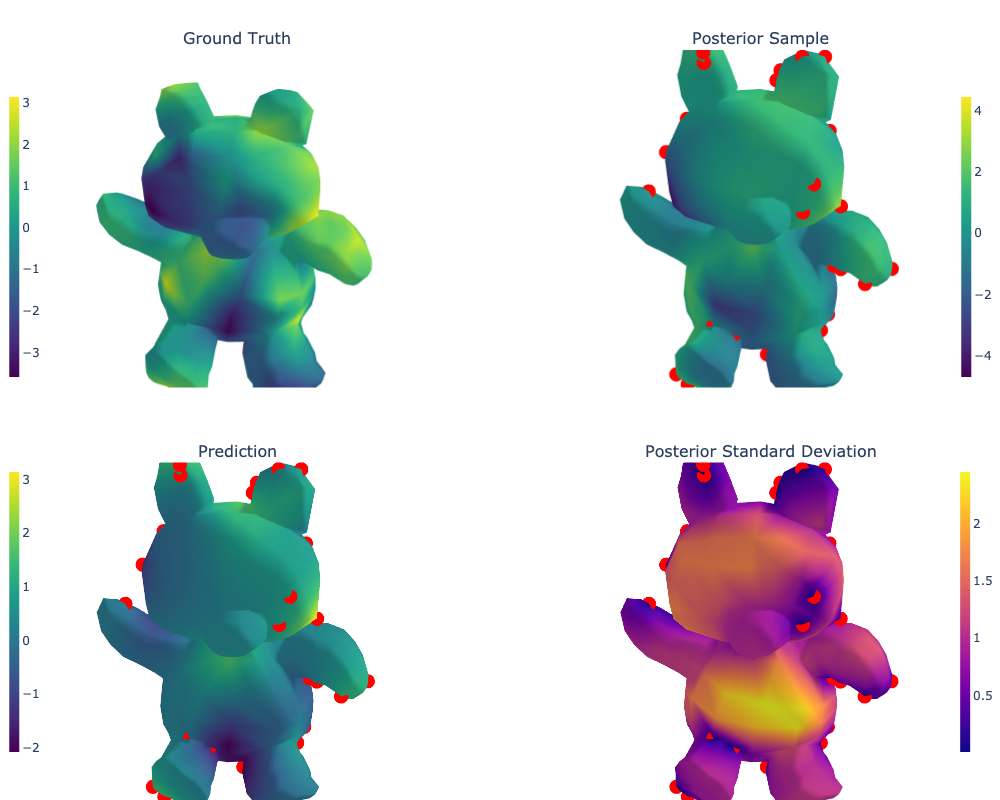

In [11]:
# Mark training data
training_data_coords = mesh.vertices[xs_train[:, 0]]

training_data_plot  = go.Scatter3d(
    x=np.array(training_data_coords[:, 0]),
    y=np.array(training_data_coords[:, 1]),
    z=np.array(training_data_coords[:, 2]),
    mode = "markers",
    marker_color = "red",
    name="",
    showlegend=False,
)

# Various plots as plotly traces
ground_truth_plot   = plot_mesh(mesh, vertices_colors=ys_test, colorscale="Viridis",
                                colorbar=dict(
                                x=0, 
                                y=0.75, 
                                xanchor="center", 
                                yanchor="middle",
                                len=0.4, 
                                thicknessmode="fraction",
                                thickness=0.01)
                               )
sample_plot         = plot_mesh(mesh, vertices_colors=sample, colorscale="Viridis",
                                colorbar=dict(
                                x=1.0, 
                                y=0.75,
                                xanchor="center", 
                                yanchor="middle",
                                len=0.4, 
                                thicknessmode="fraction",
                                thickness=0.01)
                               )

posterior_mean_plot = plot_mesh(mesh, vertices_colors=posterior_mean, colorscale="Viridis",
                                colorbar=dict(
                                x=0.0, 
                                y=0.25, 
                                xanchor="center", 
                                yanchor="middle",
                                len=0.4,
                                thicknessmode="fraction",
                                thickness=0.01)
                               )

posterior_std_plot  = plot_mesh(mesh, vertices_colors=posterior_std, colorscale="Plasma",
                                colorbar=dict(
                                x=1.0, 
                                y=0.25, 
                                xanchor="center", 
                                yanchor="middle",
                                len=0.4, 
                                thicknessmode="fraction",
                                thickness=0.01)
                               )

# Setting up the layout
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "surface"}, {"type": "surface"}],
           [{"type": "surface"}, {"type": "surface"}]],
    subplot_titles=(r"Ground Truth",
                    r"Posterior Sample",
                    r"Prediction",
                    r"Posterior Standard Deviation"),
    vertical_spacing=0.1)

# Adding the traces
fig.add_trace(ground_truth_plot,   row=1, col=1)

fig.add_trace(training_data_plot,  row=1, col=2)
fig.add_trace(sample_plot,         row=1, col=2)

fig.add_trace(training_data_plot,  row=2, col=1)
fig.add_trace(posterior_mean_plot,  row=2, col=1)

fig.add_trace(training_data_plot,  row=2, col=2)
fig.add_trace(posterior_std_plot, row=2, col=2)


fig = update_figure(fig)

fig.layout.scene1.camera = camera
fig.layout.scene2.camera = camera
fig.layout.scene3.camera = camera
fig.layout.scene4.camera = camera


fig.update_layout(
    margin={"t": 50},
)

fig.show("png", width=1000, height=800)